## Identifying pests in the PlantVillage database

In this notebook, we step through the process of training a computer vision (CV) model to distinguish among the pests in the PlantVillage database. We start with some imports below:

In [30]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


### Setting up our training and validation datasets

Our training dataset is used to teach the model how to distinguish between the various pests. Once our model has been trained, the validation dataset allows us to score how well the model performs. It is important to note that images from the validation dataset are **not used to train the model**.

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/pest_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # TODO if switch to GCP

### Sample training images

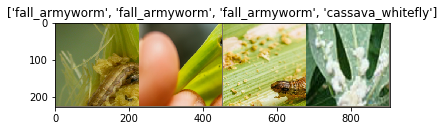

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### Model training

The code below trains the model. The model is trained over a set of 'epochs,' where each epoch represents one  step where a set of training images are passed through the model. Within each epoch, once a set of training images are passed through the model, we use gradient descent (i.e. `loss.backward` and `optimizer.step`) to tune the model's internal weights.

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)). # TODO
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs # TODO optimize
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/andrewmilich/.cache/torch/checkpoints/resnet18-5c106cde.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------
train Loss: 0.1976 Acc: 0.9070
val Loss: 0.1122 Acc: 0.9474

Epoch 1/7
----------
train Loss: 0.3098 Acc: 0.8682
val Loss: 0.0862 Acc: 0.9737

Epoch 2/7
----------
train Loss: 0.4207 Acc: 0.8527
val Loss: 0.1466 Acc: 0.9737

Epoch 3/7
----------
train Loss: 0.1912 Acc: 0.9302
val Loss: 0.1549 Acc: 0.9737

Epoch 4/7
----------
train Loss: 0.1195 Acc: 0.9535
val Loss: 0.1089 Acc: 0.9737

Epoch 5/7
----------
train Loss: 0.2834 Acc: 0.8915
val Loss: 0.0780 Acc: 0.9737

Epoch 6/7
----------
train Loss: 0.2782 Acc: 0.8992
val Loss: 0.1066 Acc: 0.9474

Epoch 7/7
----------
train Loss: 0.1513 Acc: 0.9380
val Loss: 0.0899 Acc: 0.9737

Training complete in 3m 58s
Best val Acc: 0.973684


In [38]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            print(F.softmax(outputs,dim=1))
            print(labels)
            print(preds)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([[9.9726e-01, 2.7403e-03],
        [5.5185e-05, 9.9994e-01],
        [9.9485e-06, 9.9999e-01],
        [9.9914e-01, 8.5760e-04]])
tensor([0, 1, 1, 0])
tensor([0, 1, 1, 0])


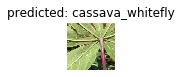

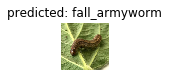

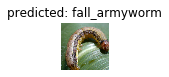

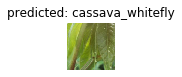

tensor([[9.9991e-01, 9.0646e-05],
        [9.9989e-01, 1.1041e-04],
        [8.9175e-05, 9.9991e-01],
        [7.2247e-01, 2.7753e-01]])
tensor([0, 0, 1, 0])
tensor([0, 0, 1, 0])


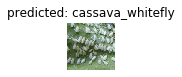

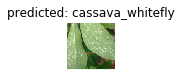

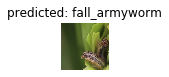

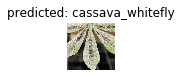

In [46]:
visualize_model(model_ft, 8)

### Credits:

[Pytorch transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

[Pytorch model finetuning](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

Google images